In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn lightgbm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Fraud Detection Jupyter Notebook

# --- 1. Import Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import lightgbm as lgb



In [4]:

# --- 2. Load Dataset ---
data = pd.read_csv("/content/drive/MyDrive/Dataset/Fraud.csv")



Dataset shape: (6362620, 11)

Missing values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Class distribution (Fraud vs Non-Fraud):
 isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


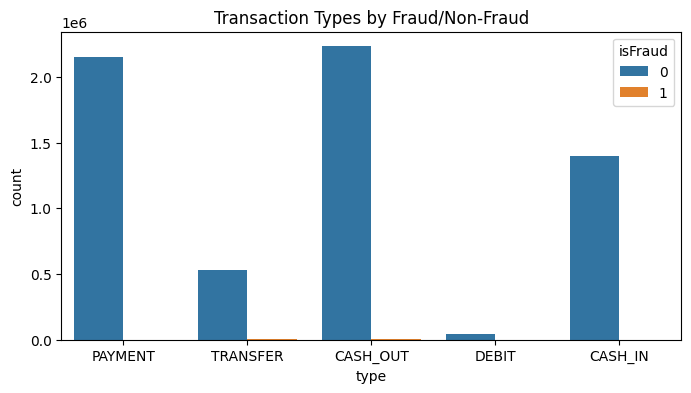

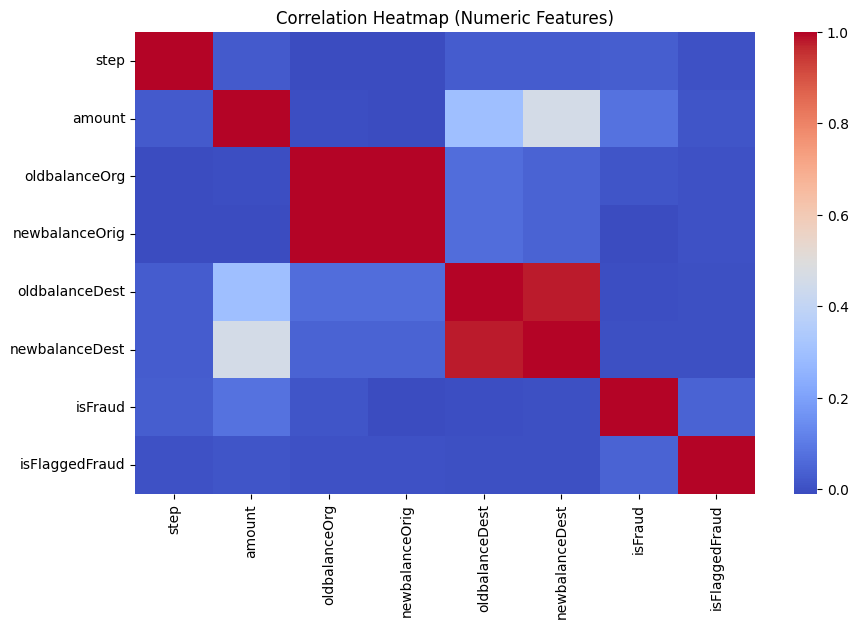

In [5]:
# --- 3. Exploratory Data Analysis (EDA) ---
print("Dataset shape:", data.shape)
print("\nMissing values:\n", data.isnull().sum())
print("\nClass distribution (Fraud vs Non-Fraud):\n", data['isFraud'].value_counts(normalize=True))

# Fraud vs Non-Fraud transaction types
plt.figure(figsize=(8,4))
sns.countplot(x='type', hue='isFraud', data=data)
plt.title("Transaction Types by Fraud/Non-Fraud")
plt.show()

# Correlation heatmap
numeric_data = data.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_data.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


In [6]:
# --- 4. Data Cleaning ---
# Handle missing values if any (check results of isnull above before applying)
data.fillna(0, inplace=True)

# Drop ID-like columns
data.drop(["nameOrig", "nameDest"], axis=1, inplace=True)

# Optional: Check correlation of isFlaggedFraud with isFraud before dropping
print("Correlation isFlaggedFraud vs isFraud:", data[['isFraud','isFlaggedFraud']].corr())
data.drop(["isFlaggedFraud"], axis=1, inplace=True)

# Encode categorical variables
le = LabelEncoder()
data['type'] = le.fit_transform(data['type'])



Correlation isFlaggedFraud vs isFraud:                  isFraud  isFlaggedFraud
isFraud         1.000000        0.044109
isFlaggedFraud  0.044109        1.000000


In [7]:
# --- 5. Feature Selection & Train/Test Split ---
X = data.drop('isFraud', axis=1)
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)



In [8]:
# --- 6. Handle Class Imbalance with SMOTE ---
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_res))



Before SMOTE: [4448085    5749]
After SMOTE: [4448085 4448085]


In [10]:
# --- 7. Model Development ---
lgb_model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=64,
    class_weight='balanced',
    random_state=42,
    device='gpu'  # Enable GPU acceleration
)
lgb_model.fit(X_train_res, y_train_res)



'''lgbm_model = LGBMClassifier(
    n_estimators=500,          # more boosting rounds
    learning_rate=0.05,        # smaller learning rate for better accuracy
    max_depth=-1,              # let LightGBM choose depth
    class_weight='balanced',   # handle imbalance
    random_state=42,
    n_jobs=-1
)
lgbm_model.fit(X_train_res, y_train_res)'''


[LightGBM] [Info] Number of positive: 4448085, number of negative: 4448085
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1535
[LightGBM] [Info] Number of data points in the train set: 8896170, number of used features: 7
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 6 dense feature groups (67.87 MB) transferred to GPU in 0.118333 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


"lgbm_model = LGBMClassifier(\n    n_estimators=500,          # more boosting rounds\n    learning_rate=0.05,        # smaller learning rate for better accuracy\n    max_depth=-1,              # let LightGBM choose depth\n    class_weight='balanced',   # handle imbalance\n    random_state=42,\n    n_jobs=-1\n)\nlgbm_model.fit(X_train_res, y_train_res)"

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.33      0.99      0.50      2464

    accuracy                           1.00   1908786
   macro avg       0.67      0.99      0.75   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix:
 [[1901421    4901]
 [     30    2434]]
ROC AUC Score: 0.9955027208544389


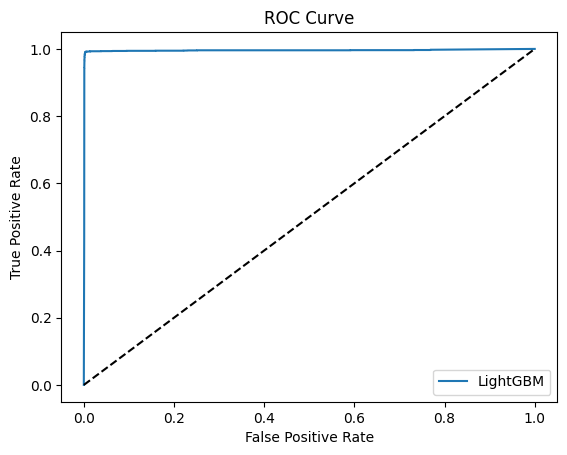

In [11]:
# --- 8. Model Evaluation ---
y_pred = lgb_model.predict(X_test)
y_prob = lgb_model.predict_proba(X_test)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label='LightGBM')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



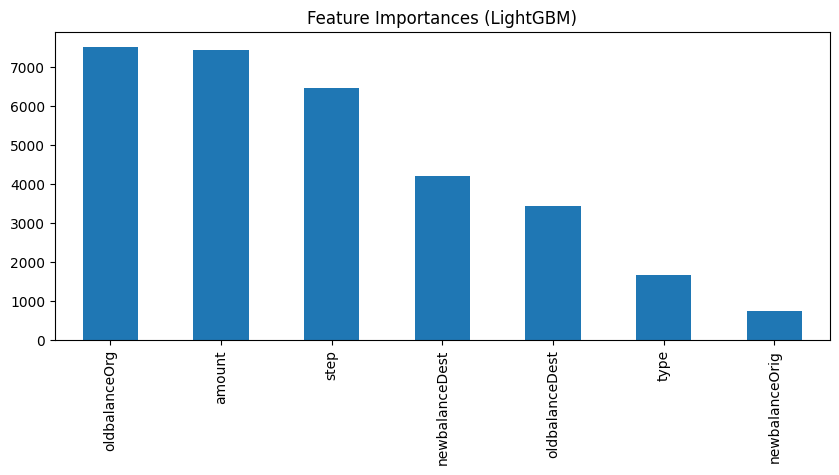

Top Predictive Factors:
oldbalanceOrg     7531
amount            7447
step              6477
newbalanceDest    4198
oldbalanceDest    3449
dtype: int32


In [12]:
# --- 9. Feature Importance ---
importances = pd.Series(lgb_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,4))
plt.title("Feature Importances (LightGBM)")
plt.show()

print("Top Predictive Factors:")
print(importances.sort_values(ascending=False).head())



In [13]:
# --- 10. Insights & Actionable Plan ---
from IPython.display import Markdown as md

insights = """
### Actionable Plan from Fraud Detection:

1. **High-Risk Transaction Types**: Transfers and Cash-Out remain most fraudulent → monitor aggressively.
2. **Balance Features**: Strong indicators of fraud; anomalies in balances must trigger alerts.
3. **Threshold Monitoring**: Apply stricter checks for large transactions.
4. **Customer Profiling**: Continue anomaly detection for unusual patterns.
5. **Infrastructure Prevention**:
   - Deploy real-time fraud detection API with this LightGBM model.
   - Multi-factor authentication for risky transfers.
   - Automated alerts for anomalies.
6. **Evaluation**:
   - Monitor fraud loss %, false positives, analyst workload.
   - A/B test rules + model vs legacy system.
"""
md(insights)


### Actionable Plan from Fraud Detection:

1. **High-Risk Transaction Types**: Transfers and Cash-Out remain most fraudulent → monitor aggressively.
2. **Balance Features**: Strong indicators of fraud; anomalies in balances must trigger alerts.
3. **Threshold Monitoring**: Apply stricter checks for large transactions.
4. **Customer Profiling**: Continue anomaly detection for unusual patterns.
5. **Infrastructure Prevention**:
   - Deploy real-time fraud detection API with this LightGBM model.
   - Multi-factor authentication for risky transfers.
   - Automated alerts for anomalies.
6. **Evaluation**:
   - Monitor fraud loss %, false positives, analyst workload.
   - A/B test rules + model vs legacy system.
